In [1]:
# load required packages
# Use pacman to load packages. 
# Running this for the first time might take time depending on whether
# these packages are already installed or not. 
install.packages("pacman", repos = "http://cran.us.r-project.org")
pacman::p_load(pacman,tidyverse,cluster,factoextra, dplyr, 
               readxl, ggplot2, mclust, NbClust, clValid,
               reshape2, fpc, radiant, pvclust,
               cowplot, gridExtra)

Warning message:
“package ‘pacman’ is not available (for R version 3.4.4)”

In [38]:
dataR <- read.csv('clean_payload_R.csv')

In [39]:
head(dataR)

data0,data1,data2,data3,data4,data5,data6,data7,flag
0,0,0,0,16,41,42,36,0
21,0,0,0,0,0,0,0,0
5,32,68,104,119,0,0,126,0
0,32,0,0,0,0,0,0,0
16,64,96,255,120,196,8,0,0
255,0,0,0,255,196,8,0,0


In [40]:
str(dataR)

'data.frame':	991371 obs. of  9 variables:
 $ data0: int  0 21 5 0 16 255 5 254 0 0 ...
 $ data1: int  0 0 32 32 64 0 33 80 0 33 ...
 $ data2: int  0 0 68 0 96 0 104 0 0 16 ...
 $ data3: int  0 0 104 0 255 0 9 0 0 255 ...
 $ data4: int  16 0 119 0 120 255 33 0 0 0 ...
 $ data5: int  41 0 0 0 196 196 33 60 6 255 ...
 $ data6: int  42 0 0 0 8 8 0 0 11 0 ...
 $ data7: int  36 0 126 0 0 0 112 0 112 0 ...
 $ flag : int  0 0 0 0 0 0 0 0 0 0 ...


In [41]:
table(dataR['flag'])


     0      1 
818164 173207 

In [6]:
out2 <- dataR %>%
  group_by(flag) %>%
  sample_n(1000)

In [7]:
dim(out2)

[1] 2000    9

In [8]:
head(out2)

data0,data1,data2,data3,data4,data5,data6,data7,flag
64,0,149,28,151,2,189,0,0
0,0,0,128,0,103,209,19,0
0,0,0,0,0,0,0,0,0
0,33,16,255,0,255,0,0,0
10,128,0,255,12,128,14,1,0
0,0,0,0,34,8,34,222,0


In [9]:
tail(out2)

data0,data1,data2,data3,data4,data5,data6,data7,flag
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1


In [10]:
class(out2)

[1] "grouped_df" "tbl_df"     "tbl"        "data.frame"

In [11]:
class(dataR)

[1] "data.frame"

In [7]:
pacman::p_load(splitstackshape)


The downloaded binary packages are in
	/var/folders/s_/d5qfzls10sz1z696lmcpvtfw0000gn/T//RtmpfrnAUS/downloaded_packages



splitstackshape installed


In [8]:
library(splitstackshape)

In [9]:
set.seed(1000)
out <- stratified(dataR, c("flag"), 1000)

In [34]:
summary(as.factor(out$flag))

0    1 
1000 1000

In [12]:
dataR <- data.frame(out2)

In [13]:
class(dataR)

[1] "data.frame"

In [14]:
dim(dataR)

[1] 2000    9

In [15]:
summary(as.factor(dataR$flag))

0    1 
1000 1000

In [16]:
# create the data to cluster on and the class variable
data.new<- dataR[,-which(names(dataR) %in% c('flag'))]
data.class<- dataR[,'flag']

In [17]:
head(data.class)

[1] 0 0 0 0 0 0

In [18]:
print('Before scaling')
head(data.new,2)
scaled_data.new<- data.new %>% mutate_each_(funs(scale(.) %>% as.vector), 
                             vars=c(names(data.new)))

rownames(scaled_data.new) <- rownames(data.new)

print('After scaling')
head(scaled_data.new,2)

[1] "Before scaling"


data0,data1,data2,data3,data4,data5,data6,data7
64,0,149,28,151,2,189,0
0,0,0,128,0,103,209,19


`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


[1] "After scaling"


data0,data1,data2,data3,data4,data5,data6,data7
0.4701456,-1.387137,1.563222,-1.1241139,1.329169,-0.4570041,4.503609,-0.41927981
-0.4225800,-1.387137,-1.267428,-0.2685848,-1.278314,1.1558201,5.011931,-0.07923856


## Try PCA

In [19]:
# the funct,ion below will beused to display scree plots for selection of PCAs. 
# The code is adopted from http://rstudio-pubs-static.s3.amazonaws.com/27823_dbc155ba66444eae9eb0a6bacb36824f.html
pcaCharts <- function(x) {
    x.var <- x$sdev ^ 2
    x.pvar <- x.var/sum(x.var)
    #print("proportions of variance:")
    #print(x.pvar)
    
    par(mfrow=c(2,2))
    plot(x.pvar,xlab="Principal component", ylab="Proportion of variance explained", ylim=c(0,1), type='b')
    plot(cumsum(x.pvar),xlab="Principal component", ylab="Cumulative Proportion of variance explained", ylim=c(0,1), type='b')
    screeplot(x)
    screeplot(x,type="l")
    par(mfrow=c(1,1))
}

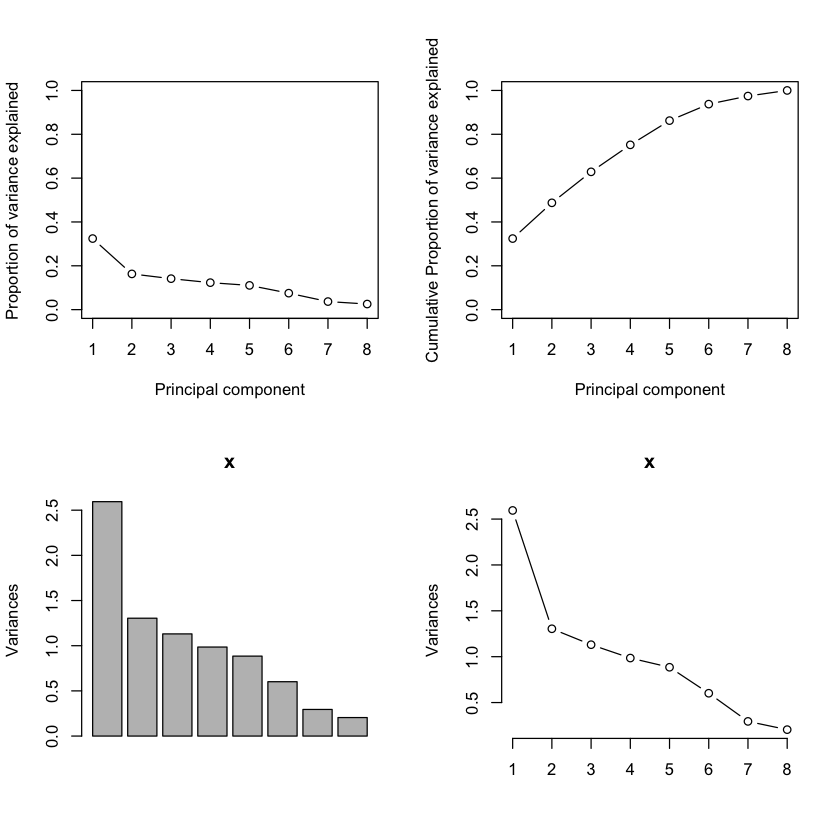

In [20]:
# Get principal component vectors using prcomp 
pc <- prcomp(scaled_data.new)
pcaCharts(pc)

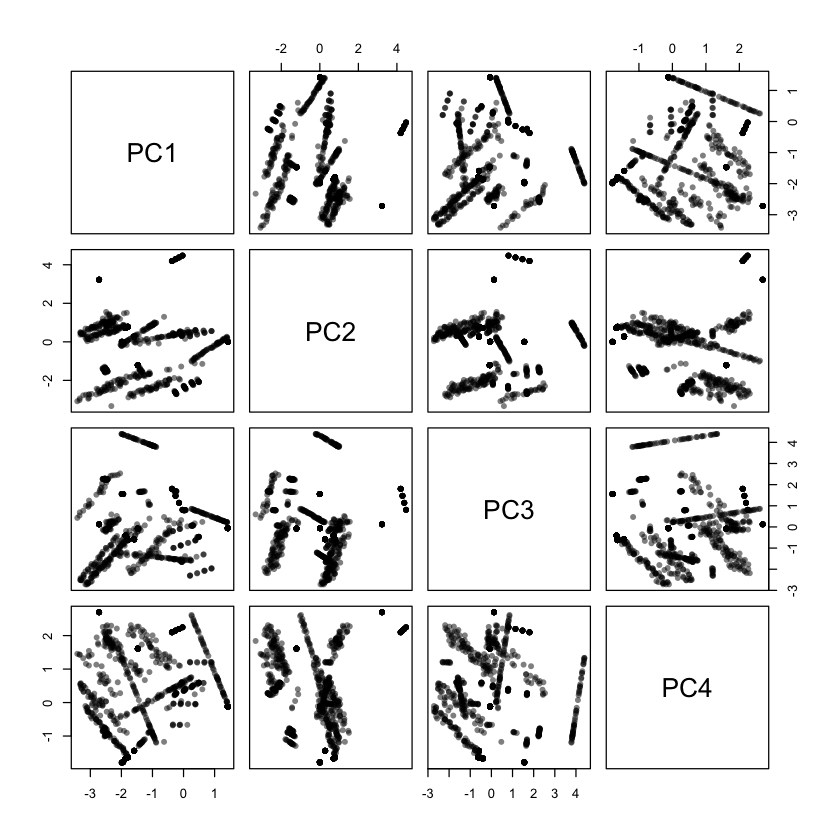

In [21]:
# a look at the first 4 principal components
# First four principal components
comp <- data.frame(pc$x[,1:4])
# Plot
plot(comp, pch=16, col=rgb(0,0,0,0.5))

## K-means clustering


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



[1] "clustering with centers(k) =2"
[1] "Clusters content"


[1]  785 1215

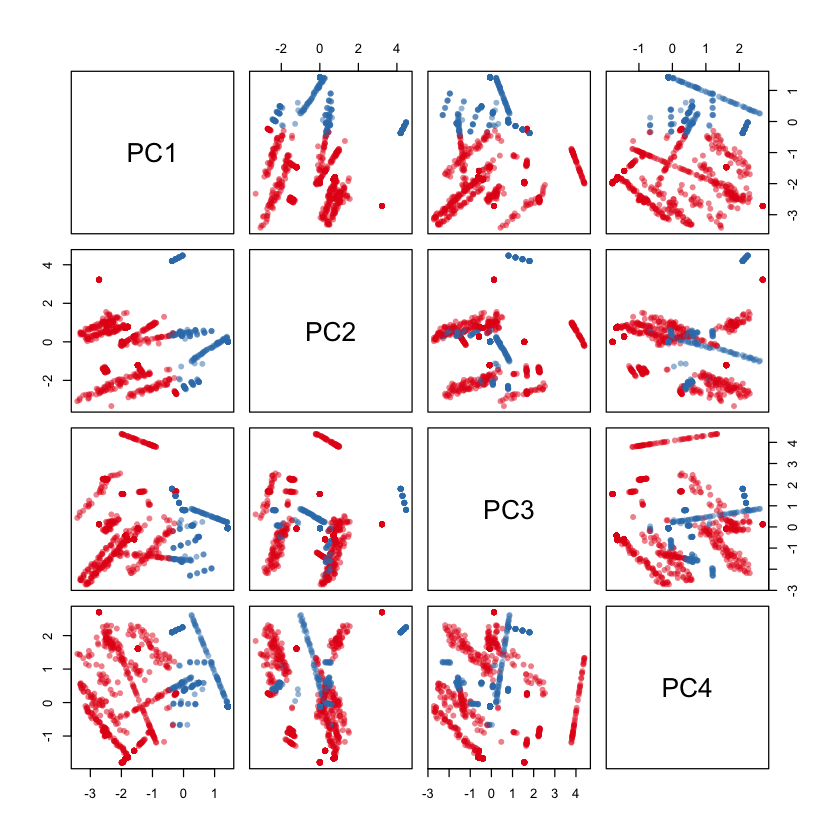

In [22]:
# Apply k-means with k=2
k2 <- kmeans(comp, 2, nstart=25, iter.max=1000)
library(RColorBrewer)
library(scales)
print('clustering with centers(k) =2')

print('Clusters content')
k2$size # gives no. of records in each cluster
palette(alpha(brewer.pal(9,'Set1'), 0.5))
plot(comp, col=k2$clust, pch=16)

#pulling the first two dimensions only to compare later on
p2 <- fviz_cluster(k2, geom = "point", data = comp, stand = FALSE, ellipse.type = "norm") + ggtitle("k = 2")

In [23]:
# How does the clustering model do?
table(data.frame(data.class, k2$cluster))

          k2.cluster
data.class    1    2
         0  785  215
         1    0 1000

[1] "clustering with centers(k) =2"
[1] "Clusters content"


[1]   50   89   97  235 1035  123  176   72   52   71

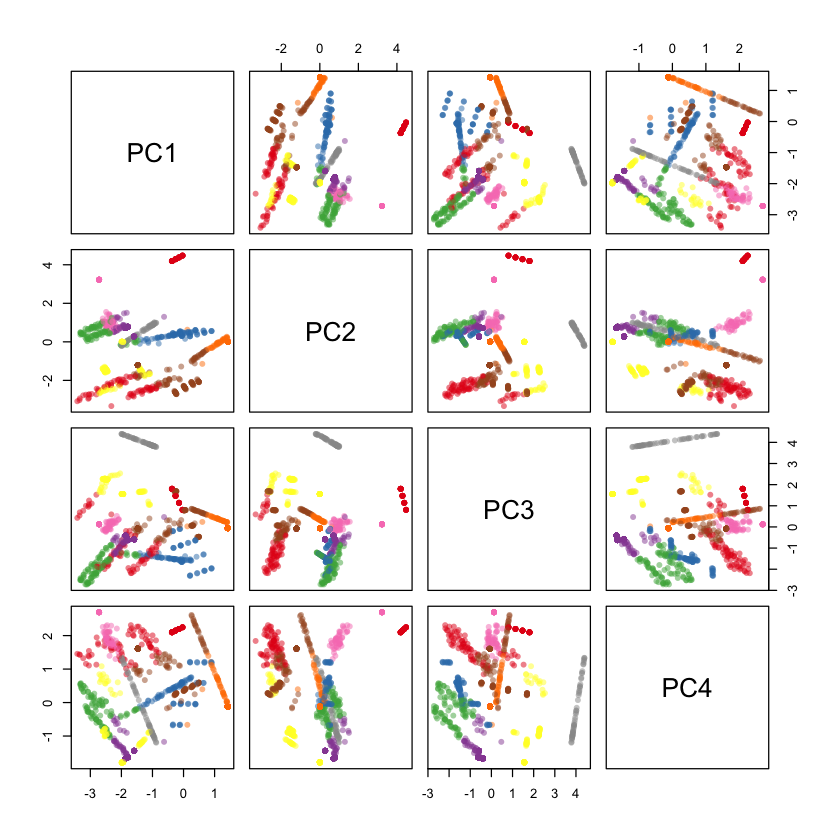

In [24]:
# Apply k-means with k=10
k10 <- kmeans(comp, 10, nstart=25, iter.max=1000)
#library(RColorBrewer)
#library(scales)
print('clustering with centers(k) =2')

print('Clusters content')
k10$size # gives no. of records in each cluster
palette(alpha(brewer.pal(9,'Set1'), 0.5))
plot(comp, col=k10$clust, pch=16)

#pulling the first two dimensions only to compare later on
p10 <- fviz_cluster(k10, geom = "point", data = comp, stand = FALSE, ellipse.type = "norm") + ggtitle("k = 10")

In [25]:
# How does the clustering model do?
table(data.frame(data.class, k10$cluster))

          k10.cluster
data.class    1    2    3    4    5    6    7    8    9   10
         0   50   89   97  235   35  123  176   72   52   71
         1    0    0    0    0 1000    0    0    0    0    0

[1] "clustering with centers(k) =20"
[1] "Clusters content"


[1]   21   22   33   29   52   42 1025   23   33   88   29   45   47   50   50   22   31   81  235   42

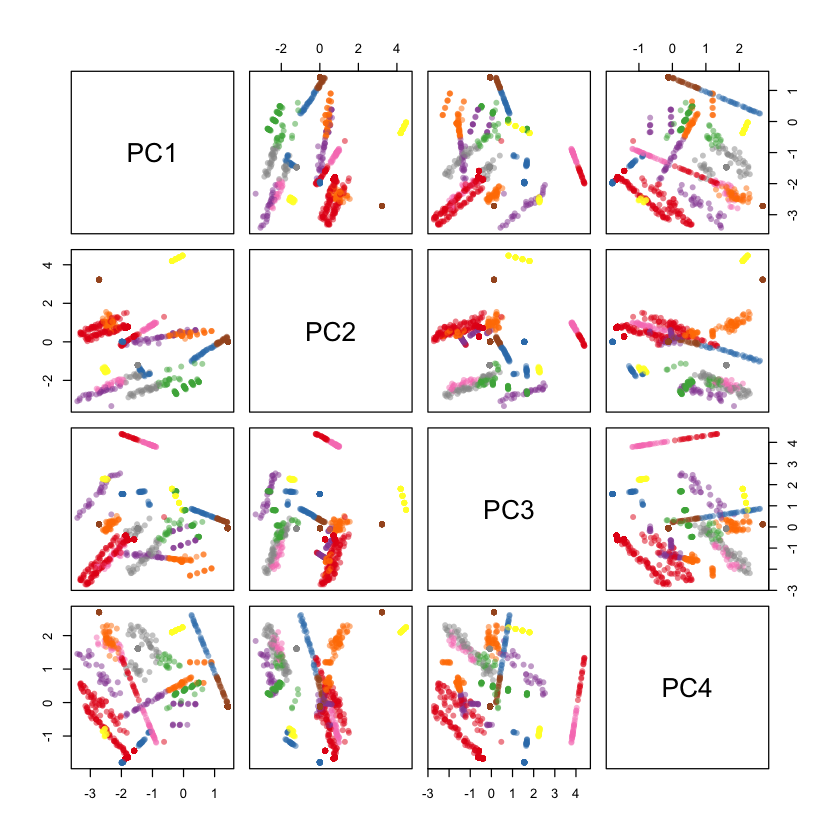

In [26]:
# Apply k-means with k=20
k20 <- kmeans(comp, 20, nstart=25, iter.max=1000)
#library(RColorBrewer)
#library(scales)
print('clustering with centers(k) =20')

print('Clusters content')
k20$size # gives no. of records in each cluster
palette(alpha(brewer.pal(9,'Set1'), 0.5))
plot(comp, col=k20$clust, pch=16)

#pulling the first two dimensions only to compare later on
p20 <- fviz_cluster(k20, geom = "point", data = comp, stand = FALSE, ellipse.type = "norm") + ggtitle("k = 20")

In [27]:
# How does the clustering model do?
table(data.frame(data.class, k20$cluster))

          k20.cluster
data.class    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20
         0   21   22   33   29   52   42   25   23   33   88   29   45   47   50   50   22   31   81  235   42
         1    0    0    0    0    0    0 1000    0    0    0    0    0    0    0    0    0    0    0    0    0

## Visualize with circles

Warning message:
“Computation failed in `stat_ellipse()`:
the leading minor of order 1 is not positive definite”

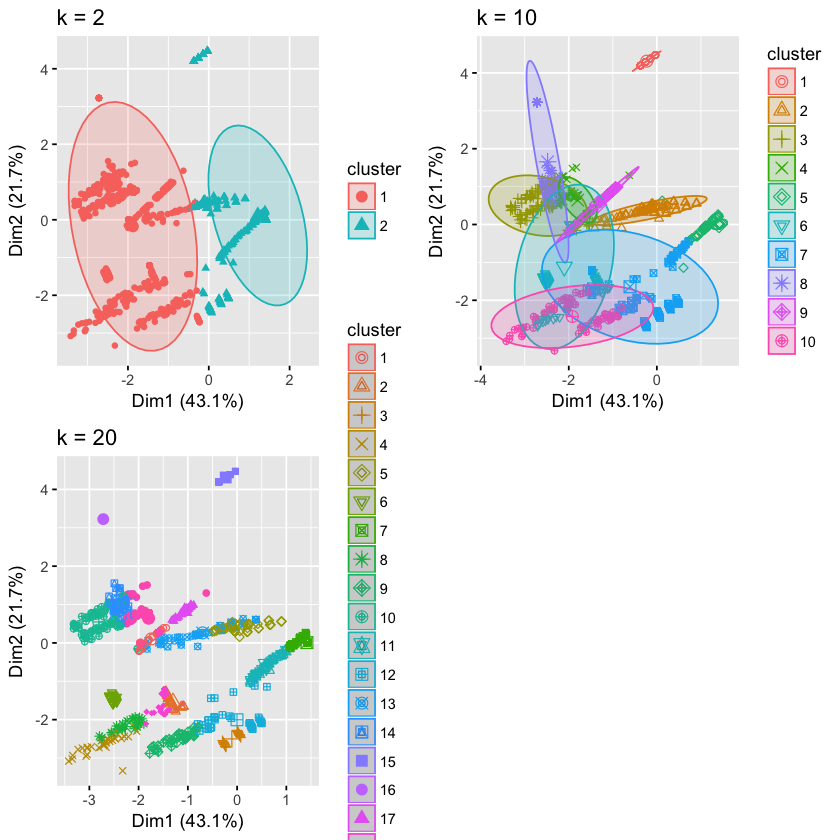

In [29]:
# plots to compare
grid.arrange(p2, p10, p20, nrow=2)

## Measure k-means effectiveness

In [50]:
clt <- scaled_data.new

# K-means models
km2 <- eclust(clt, "kmeans", k=2, nstart=25, graph = F)
km5 <- eclust(clt, "kmeans", k=5, nstart=25, graph = F)
km10 <- eclust(clt, "kmeans", k=10, nstart=25, graph = F)
km20 <- eclust(clt, "kmeans", k=20, nstart=25, graph = F)

In [51]:
km2_plot <- fviz_silhouette(km2, palette="jco", ggtheme = theme_classic())

  cluster size ave.sil.width
1       1 1274          0.70
2       2  726          0.13


In [52]:
km5_plot <- fviz_silhouette(km5, palette="jco", ggtheme = theme_classic())

  cluster size ave.sil.width
1       1  154          0.29
2       2 1173          0.79
3       3  382          0.43
4       4  211          0.24
5       5   80          0.65


In [53]:
km10_plot <- fviz_silhouette(km10, palette="jco", ggtheme = theme_classic())

   cluster size ave.sil.width
1        1  133          0.49
2        2  131          0.23
3        3 1047          0.96
4        4   73          0.66
5        5  286          0.60
6        6   58          0.67
7        7   61          0.88
8        8   52          0.70
9        9   93          0.35
10      10   66          0.58


In [57]:
km20_plot <- fviz_silhouette(km20, palette="npg", ggtheme = theme_classic())

   cluster size ave.sil.width
1        1  219          0.76
2        2   30          0.73
3        3   61          0.27
4        4   69          0.47
5        5   47          0.76
6        6   27          0.57
7        7   28          0.78
8        8   23          0.60
9        9   78          0.43
10      10   29          0.61
11      11   20          0.44
12      12   40          0.98
13      13 1024          0.99
14      14   26          0.30
15      15   28          0.67
16      16   36          0.43
17      17   83          0.57
18      18   61          0.88
19      19   52          1.00
20      20   19          1.00


Warning message:
“This manual palette can handle a maximum of 10 values. You have supplied 20.”Warning message:
“This manual palette can handle a maximum of 10 values. You have supplied 20.”

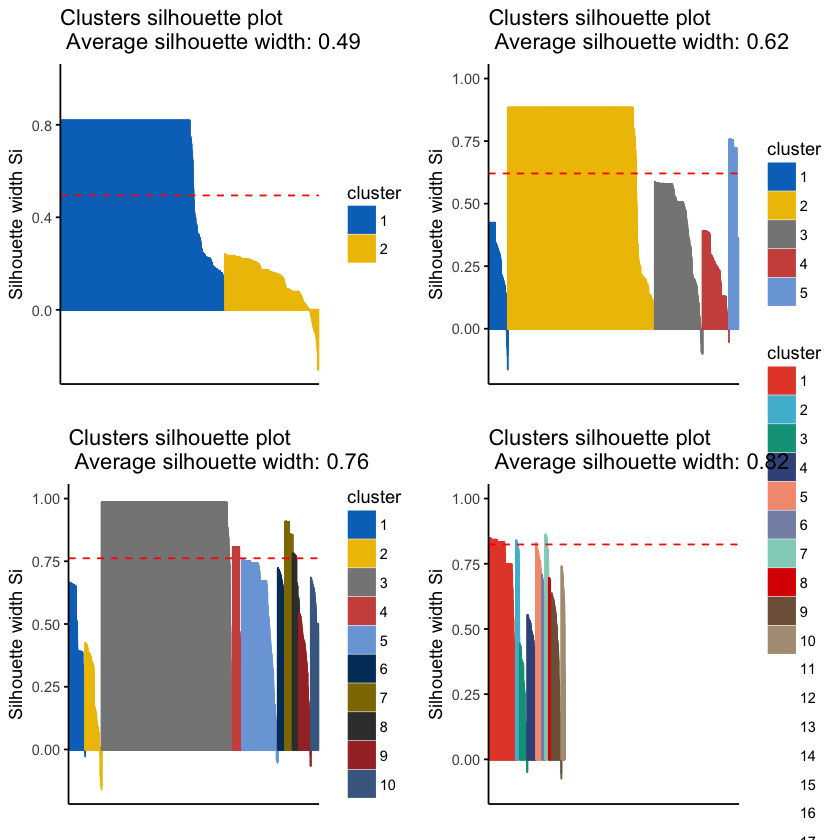

In [58]:
plot_grid(km2_plot, km5_plot, km10_plot, km20_plot)

Warning message:
“This manual palette can handle a maximum of 10 values. You have supplied 20.”Warning message:
“This manual palette can handle a maximum of 10 values. You have supplied 20.”

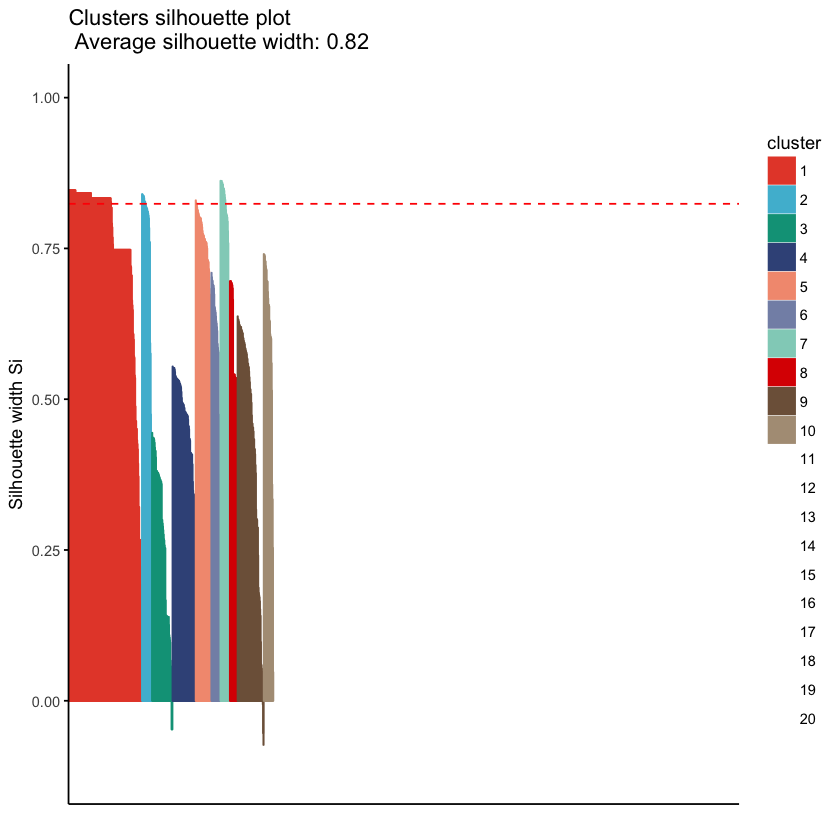

In [59]:
plot(km20_plot)palette

In [60]:
getPalette = colorRampPalette(brewer.pal(9, "Set1"))

In [61]:
km20_plot <- fviz_silhouette(km20, palette=getPalette(20), ggtheme = theme_classic())

   cluster size ave.sil.width
1        1  219          0.76
2        2   30          0.73
3        3   61          0.27
4        4   69          0.47
5        5   47          0.76
6        6   27          0.57
7        7   28          0.78
8        8   23          0.60
9        9   78          0.43
10      10   29          0.61
11      11   20          0.44
12      12   40          0.98
13      13 1024          0.99
14      14   26          0.30
15      15   28          0.67
16      16   36          0.43
17      17   83          0.57
18      18   61          0.88
19      19   52          1.00
20      20   19          1.00


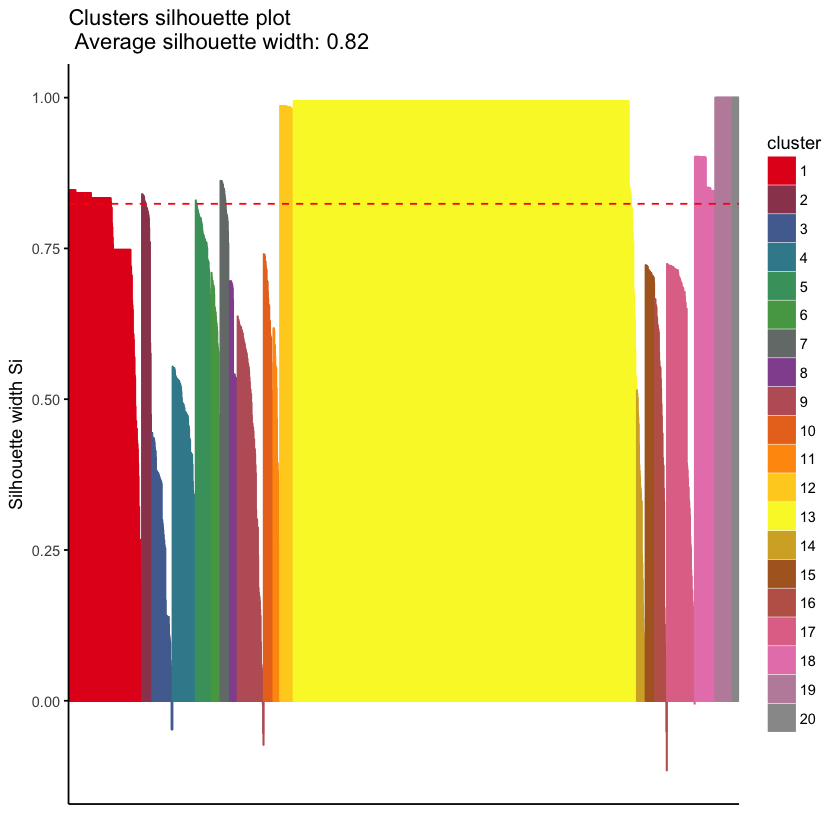

In [62]:
plot(km20_plot)

## Hierarchichal Clustering

In [31]:
head(scaled_data.new)

data0,data1,data2,data3,data4,data5,data6,data7
0.4701456,-1.3871374,1.5632217,-1.1241139,1.3291687,-0.4570041,4.50360876,-0.41927981
-0.4225800,-1.3871374,-1.2674283,-0.2685848,-1.2783142,1.1558201,5.01193109,-0.07923856
-0.4225800,-1.3871374,-1.2674283,-1.3636620,-1.2783142,-0.4889412,-0.30003726,-0.41927981
-0.4225800,-0.5773093,-0.9634659,0.8179371,-1.2783142,3.5830407,-0.30003726,-0.41927981
-0.2830917,1.7540141,-1.2674283,0.8179371,-1.0710970,1.5550340,0.05578838,-0.40138290
-0.4225800,-1.3871374,-1.2674283,-1.3636620,-0.6911988,-0.3611928,0.56411071,3.55383373


In [32]:
dim(scaled_data.new)

[1] 2000    8

In [42]:
out3 <- dataR %>%
  group_by(flag) %>%
  sample_n(250)

In [43]:
dim(out3)

[1] 500   9

In [44]:
dataHR <- data.frame(out3)

In [45]:
# create the data to cluster on and the class variable
data.new<- dataHR[,-which(names(dataHR) %in% c('flag'))]
data.class<- dataHR[,'flag']

In [46]:
print('Before scaling')
head(data.new,2)
scaled_data.new<- data.new %>% mutate_each_(funs(scale(.) %>% as.vector), 
                             vars=c(names(data.new)))

rownames(scaled_data.new) <- rownames(data.new)

print('After scaling')
head(scaled_data.new,2)

[1] "Before scaling"


data0,data1,data2,data3,data4,data5,data6,data7
0,0,0,0,26,0,40,114
8,0,0,0,0,0,0,0


`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


[1] "After scaling"


data0,data1,data2,data3,data4,data5,data6,data7
-0.4369202,-1.352414,-1.255557,-1.311629,-0.8611368,-0.4800737,0.8361166,1.6534785
-0.3350443,-1.352414,-1.255557,-1.311629,-1.2869557,-0.4800737,-0.2948405,-0.4105633


In [47]:
# make a copy 
hrc <- scaled_data.new

In [48]:
dim(hrc)

[1] 500   8

In [49]:
# calculate the distance matrix
hrc.dist <- dist(hrc)

In [50]:
# Use complete linkage method
hrc.link <- hclust(d = hrc.dist, method="complete")

Warning message in data.frame(xmin = unlist(xleft), ymin = unlist(ybottom), xmax = unlist(xright), :
“row names were found from a short variable and have been discarded”

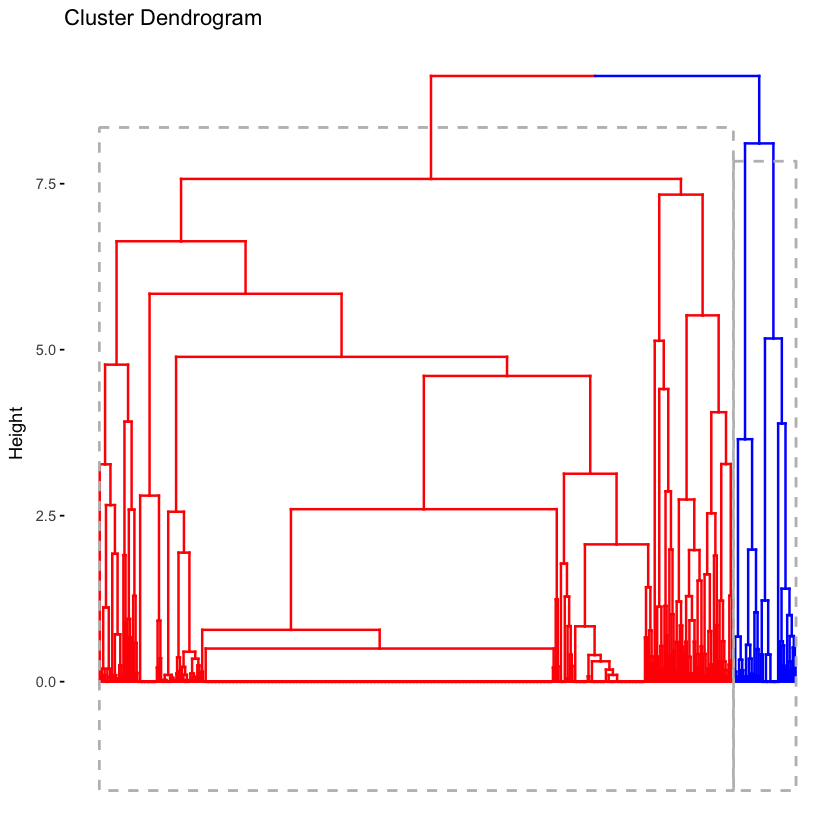

In [51]:
# Cut the dendrogram into 2 groups
fviz_dend(hrc.link, k=2, # Cut into 2 groups
          show_labels= F, # don't show labels
         k_colors = c("red", "blue"),
         rect = T)

#fviz_dend(hrc.link, cex=0.5, show_labels = F)

In [52]:
hrc.clusters <- cutree(hrc.link, k=2)

In [53]:
table(hrc.clusters)

hrc.clusters
  1   2 
455  45 

In [54]:
table(data.class)

data.class
  0   1 
250 250 

### Using ward2 linkage method

Warning message in data.frame(xmin = unlist(xleft), ymin = unlist(ybottom), xmax = unlist(xright), :
“row names were found from a short variable and have been discarded”

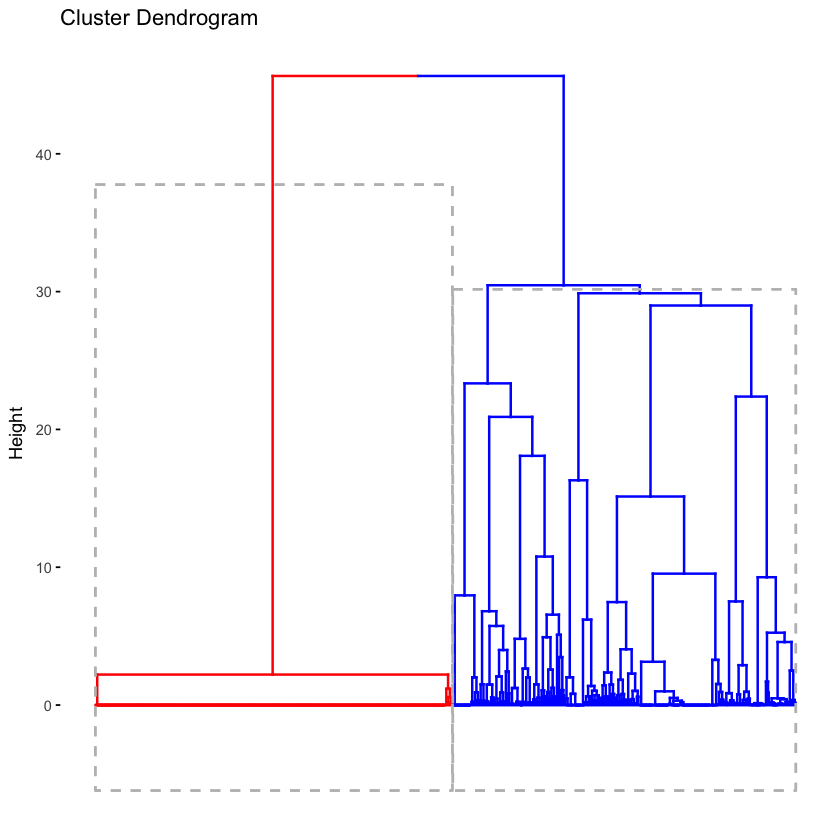

In [55]:
# Use complete linkage method
hrc.link.ward2 <- hclust(d = hrc.dist, method="ward.D2")

# Cut the dendrogram into 2 groups
fviz_dend(hrc.link.ward2, k=2, # Cut into 2 groups
          show_labels= F, # don't show labels
         k_colors = c("red", "blue"),
         rect = T)

In [56]:
hrc.ward2.clusters <- cutree(hrc.link.ward2, k=2)
table(hrc.ward2.clusters)

hrc.ward2.clusters
  1   2 
245 255 

## Preparing data for matlab

In [57]:
out4 <- dataR %>%
  group_by(flag) %>%
  sample_n(500)

In [58]:
dim(out4)

[1] 1000    9

In [59]:
summary(as.factor(out4$flag))

0   1 
500 500

In [62]:
# Write CSV in R
write.csv(out4, file = "SOM.csv",row.names=FALSE)

In [63]:
out5 <- subset(out4, select = -c(flag))

In [64]:
dim(out5)

[1] 1000    8

In [66]:
head(out5)

data0,data1,data2,data3,data4,data5,data6,data7
0,0,0,0,18,37,39,209
0,0,0,128,0,103,209,19
21,0,0,0,0,0,0,0
0,0,0,0,10,38,44,222
242,127,0,0,42,127,10,213
5,29,40,13,29,29,0,112


In [67]:
write.csv(out5, file = "SOM1.csv",row.names=FALSE)

In [68]:
dim(dataR)

[1] 991371      9

In [69]:
out6 <- dataR %>%
  group_by(flag) %>%
  filter(flag == 0)

In [70]:
dim(out6)

[1] 818164      9

In [71]:
summary(as.factor(dataR$flag))

0      1 
818164 173207

In [72]:
out7 <- out6 %>%
        sample_n(50000)

In [73]:
dim(out7)

[1] 50000     9

In [74]:
head(out7)

data0,data1,data2,data3,data4,data5,data6,data7,flag
0,0,0,128,0,103,209,19,0
254,81,0,0,0,60,0,0,0
0,0,0,0,0,8,9,165,0
10,128,0,255,19,128,2,3,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,5,15,208,0


In [75]:
out8 <- dataR %>%
  group_by(flag) %>%
  filter(flag == 1)

In [76]:
dim(out8)

[1] 173207      9

In [77]:
out9 <- out8 %>%
        sample_n(10000)

In [78]:
dim(out9)

[1] 10000     9

In [79]:
head(out9)

data0,data1,data2,data3,data4,data5,data6,data7,flag
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1


In [83]:
out10 <- rbind(out7, out9)

In [84]:
dim(out10)

[1] 60000     9

In [85]:
tail(out10)

data0,data1,data2,data3,data4,data5,data6,data7,flag
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1
1,69,96,255,107,0,0,0,1


In [86]:
head(out10)

data0,data1,data2,data3,data4,data5,data6,data7,flag
0,0,0,128,0,103,209,19,0
254,81,0,0,0,60,0,0,0
0,0,0,0,0,8,9,165,0
10,128,0,255,19,128,2,3,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,5,15,208,0


In [87]:
write.csv(out10, file = "spoofingSupervisedClassification.csv",row.names=FALSE)